In [1]:
import torch as tn
import torch.nn as nn
import torch.nn.functional as F
import torchtt as tntt
import numpy as np
import tt_iga
import matplotlib.pyplot as plt
import torch as tn
import datetime

tn.set_default_dtype(tn.float64)

In [2]:

def create_geometry( ):
        
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    # Dc = 32e-3
    # hc = 7e-3
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri

    get_rO = lambda Ax,Ay,ri: (Ax**2+Ay**2-ri**2)/(np.sqrt(2)*(Ax+Ay)-2*ri)

    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)

    def Cx(ri,Dc,hc):
        O = [((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2),((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2)]
        A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
        b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
        C = np.linalg.solve(A,b)
        return C[0]

    def Cy(ri,Dc,hc):
        O = [((Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri) )/np.sqrt(2),( (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)  )/np.sqrt(2)]
        A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
        b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
        C = np.linalg.solve(A,b)
        return C[1]

    control_points = tt_iga.geometry.ParameterDependentControlPoints([7,5])

    # params ri - 0 , Dc - 1 , Di - 2 
    control_points[:,0,0] = [0,0]
    control_points[:,1,0] = [lambda params: (Dc+params[1])/2, 0]
    control_points[:,2,0] = [lambda params: (Dc+params[1]), 0]
    control_points[:,3,0] = [(Dc+Di)/2,0]
    control_points[:,4,0] = [lambda params: Di+params[2],0]
    control_points[:,5,0] = [(Do+Di)/2,0]
    control_points[:,6,0] = [Do,0]
    
    control_points[:,0,1] = [lambda params: (ri+params[0])/np.sqrt(2)*0.5,lambda params: (ri+params[0])/np.sqrt(2)*0.5]
    control_points[:,1,1] = [lambda params: (Cx(ri,Dc,hc)+Dc/2)*0.5, lambda params: Cy(ri,Dc,hc)*0.5]
    control_points[:,2,1] = [lambda params: (Dc+params[1]), hc*0.5]
    control_points[:,3,1] = [(Dc+Di)/2,0.5*(hi-bli+hc)*0.5]
    control_points[:,4,1] = [lambda params: Di+params[2],(hi-bli)*0.5]
    control_points[:,5,1] = [(Do+Di)/2,(hi-bli)*0.5]
    control_points[:,6,1] = [Do,(hi-bli)*0.5]

    #control_points[:,0,1] = [lambda params: (ri+params[0])/np.sqrt(2)*0.5,lambda params: (ri+params[0])/np.sqrt(2)*0.5]
    #control_points[:,1,1] = [lambda params: (Cx(ri+params[0],Dc+params[1],hc)+(Dc+params[1])/2)*0.5, lambda params: Cy(ri+params[0],Dc+params[1],hc)*0.5]
    #control_points[:,2,1] = [lambda params: (Dc+params[1]), hc*0.5]
    #control_points[:,3,1] = [(Dc+Di)/2,0.5*(hi-bli+hc)*0.5]
    #control_points[:,4,1] = [lambda params: Di+params[2],(hi-bli)*0.5]
    #control_points[:,5,1] = [(Do+Di)/2,(hi-bli)*0.5]
    #control_points[:,6,1] = [Do,(hi-bli)*0.5]
    
    control_points[:,0,2] = [lambda params: (ri+params[0])/np.sqrt(2),lambda params: (ri+params[0])/np.sqrt(2)]
    control_points[:,1,2] = [lambda params: Cx(ri+params[0],Dc+params[1],hc), lambda params: Cy(ri+params[0],Dc+params[1],hc)]
    control_points[:,2,2] = [lambda params: (Dc+params[1]), hc]
    control_points[:,3,2] = [(Dc+Di)/2,0.5*(hi-bli+hc)]
    control_points[:,4,2] = [lambda params: Di+params[2],hi-bli]
    control_points[:,5,2] = [(Do+Di)/2,hi-bli]
    control_points[:,6,2] = [Do,hi-bli]
    
    control_points[:,0,3] = [(0.75*ri+0.25*Do)/np.sqrt(2),(0.75*ri+0.25*Do)/np.sqrt(2)]
    control_points[:,1,3] = [0.5*((0.75*ri+0.25*Do)/np.sqrt(2)+Dc+blc), 0.5*((0.75*ri+0.25*Do)/np.sqrt(2)+hi)]
    control_points[:,2,3] = [Dc+blc,lambda params:  hi+params[3]]
    control_points[:,3,3] = [ 0.5*(Dc+blc+Di-bli),lambda params:  hi+params[3]]
    control_points[:,4,3] = [ Di-bli, lambda params: hi+params[3]]
    control_points[:,5,3] = [lambda params: 0.5*(Di+Do),hi]
    control_points[:,6,3] = [Do,hi]

    control_points[:,0,4] = [Do/np.sqrt(2), Do/np.sqrt(2)]
    control_points[:,1,4] = [Do/np.sqrt(2)*(1-0.5*Dc/Do)+Do*(0.5*Dc/Do), Do/np.sqrt(2)*(1-0.5*Dc/Do)+Do*np.tan(np.pi/8)*(0.5*Dc/Do)]
    control_points[:,2,4] = [Do/np.sqrt(2)*(1-Dc/Do)+Do*(Dc/Do), Do/np.sqrt(2)*(1-Dc/Do)+Do*np.tan(np.pi/8)*(Dc/Do)]
    control_points[:,3,4] = [Do/np.sqrt(2)*(1-0.5*(Dc+Di)/Do)+Do*(0.5*(Dc+Di)/Do), Do/np.sqrt(2)*(1-0.5*(Dc+Di)/Do)+Do*np.tan(np.pi/8)*(0.5*(Dc+Di)/Do)]
    control_points[:,4,4] = [Do/np.sqrt(2)*(1-Di/Do)+Do*(Di/Do), Do/np.sqrt(2)*(1-Di/Do)+Do*np.tan(np.pi/8)*(Di/Do)]
    control_points[:,5,4] = [Do/np.sqrt(2)*(1-0.5*(Di+Do)/Do)+Do*(0.5*(Di+Do)/Do), Do/np.sqrt(2)*(1-0.5*(Di+Do)/Do)+Do*np.tan(np.pi/8)*(0.5*(Di+Do)/Do)]
    control_points[:,6,4] = [Do,Do*np.tan(np.pi/8)]

    weights = tt_iga.geometry.ParameterDependentWeights([7,5])
    weights[...] = 1.0
    alpha2 = lambda params: np.math.asin((hc-get_rO(Dc+params[1],hc,ri+params[0])/np.sqrt(2))/(get_rO(Dc+params[1],hc,ri+params[0])-ri-params[0]))
    weights[1,2] = lambda params :  np.sin((np.pi-np.abs(alpha2(params)+np.pi*3/4))/2)
    # weights[1,2] = lambda params :  np.abs(alpha2+np.pi*3/4)
    
    surface_excitation = lambda params: 0.5*(blc-params[...,1])*(hi+params[...,3]+hc)+(Di-bli-Dc-blc)*(hi+params[...,3])+0.5*(bli+params[...,2])*(hi+params[...,3]+hi-bli)
    return control_points, weights, surface_excitation

In [3]:
control_points, weights, surface = create_geometry()
print(surface(np.array([0.0,0.0,0.0,0.0])))

var1 = 0.00075
var2 = 0.00075
var3 = 0.00075
var4 = 0.00075

basis1 = tt_iga.bspline.BSplineBasis(np.array([0,0.4,0.4,0.6,0.6,1]),2)
basis2 = tt_iga.bspline.BSplineBasis(np.array([0,0.15,0.3,0.5,1]),1)
basis = [basis1, basis2]
basis_solution = [tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.4,21), np.linspace(0.4,0.6,21),np.linspace(0.6,1,21))),2)]
basis_solution.append(tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.15,16),np.linspace(0.15,0.3,15), np.linspace(0.3,0.5,15),np.linspace(0.5,1,17))),2))

nl = 10
basis_param = [tt_iga.lagrange.LagrangeLeg(nl,[-var1,var1]), tt_iga.lagrange.LagrangeLeg(nl,[-var2,var2]), tt_iga.lagrange.LagrangeLeg(nl,[-var3,var3]), tt_iga.lagrange.LagrangeLeg(nl,[-var4,var4])]
geom = tt_iga.PatchNURBS.interpolate_parameter_dependent(control_points, weights, basis, basis_param, eps = 1e-13)


0.0002177263404511999


In [4]:
mu0 = 4*np.pi*1e-7
mur = 1500
mu_ref = lambda y: 1/mu0*((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))+1/(mu0*mur)*tn.logical_not((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))

tme = datetime.datetime.now()
Mass_tt = geom.mass_interp(basis_solution, eps = 1e-10)
tme = datetime.datetime.now() - tme
print('Time mass ', tme)
tme = datetime.datetime.now()
Stiff_tt = geom.stiffness_interp(basis_solution, eps = 1e-10, func_reference=mu_ref, qtt = True, verb = True, device = 'cuda:1')
tme = datetime.datetime.now() - tme
print('Time stiffness ', tme)

Jref = lambda y: 24*45/surface(y[...,2:])*(y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+0.0
# Jref = lambda y: 5000000*(y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+0.0

rhs_tt = geom.rhs_interp(basis_solution,Jref)

P1 = tn.eye(Mass_tt.N[0])
P2 = tn.eye(Mass_tt.N[1])
P2[-1,-1] = 0
P1[0,0] = 0
P1[-1,-1] = 0
Pin_tt = tntt.rank1TT([P1,P2]) ** tntt.eye([nl]*4)
Pbd_tt = (tntt.eye(Mass_tt.N) - Pin_tt) ** tntt.eye([nl]*4) / Mass_tt.N[0]

M_tt = (Pin_tt@Stiff_tt+Pbd_tt).round(1e-10)
rhs_tt = (Pin_tt @ rhs_tt + 0).round(1e-10)

print('System matrix... ',flush=True)

print('Rank Stiff', Stiff_tt.R, ' storage [MB] ',tntt.numel(Stiff_tt)*8/1e6)
print('Rank Mass', Mass_tt.R, ' storage [MB] ',tntt.numel(Mass_tt)*8/1e6)
print('Rank Mtt ',M_tt.R, ' storage [MB] ',tntt.numel(M_tt)*8/1e6)
print('Rank rhstt ',rhs_tt.R, ' storage [MB] ',tntt.numel(rhs_tt)*8/1e6)


Time mass  0:00:01.714397
time omega 0:00:01.630299
rank omega, [1, 18, 22, 11, 4, 2, 1]
QTT enabled:
[240, 236, 10, 10, 10, 10]
  || 
  \/  
[2, 2, 2, 2, 3, 5, 2, 2, 59, 2, 5, 2, 5, 2, 5, 2, 5]
rank of Ftt is  [1, 3, 1, 1, 1, 1, 1]
alpha, beta =  0 0
	time 1  0:00:00.605325
	time 2  0:00:05.029045  rank  [1, 4, 16, 56, 160, 432, 276, 436, 678, 99, 218, 87, 178, 77, 100, 10, 10, 1]
		time  0:00:00.119876
	time 4  0:00:00.122635
alpha, beta =  0 1
	time 1  0:00:00.584810
	time 2  0:00:03.865954  rank  [1, 4, 16, 56, 160, 432, 300, 468, 756, 110, 236, 96, 196, 85, 100, 10, 10, 1]
		time  0:00:00.133053
	time 4  0:00:00.138781
	time ROUND  0:00:00.455762
alpha, beta =  1 0
	time 1  0:00:00.591154
	time 2  0:00:03.852284  rank  [1, 4, 16, 56, 160, 432, 300, 468, 756, 110, 236, 96, 196, 85, 100, 10, 10, 1]
		time  0:00:00.131452
	time 4  0:00:00.136971
alpha, beta =  1 1
	time 1  0:00:00.571309
	time 2  0:00:03.232459  rank  [1, 4, 16, 56, 160, 432, 264, 412, 696, 99, 212, 86, 176, 77, 100,

In [5]:
tme = datetime.datetime.now() 
dev_name = 'cuda:1'
dofs_tt = tntt.solvers.amen_solve(M_tt.to(dev_name), rhs_tt.to(dev_name), x0 = tntt.ones(rhs_tt.N).to(dev_name), rmax = 300, eps = 1e-6, nswp = 50, kickrank = 8, preconditioner = 'c', verbose = False).cpu()
tme = datetime.datetime.now() - tme
print('Time system solve ',tme,flush=True)

Time system solve  0:02:56.169456


In [6]:
fspace = tt_iga.Function(basis_solution+basis_param)
fspace.dofs = dofs_tt.round(1e-10)

In [7]:
dofs_tt.N

[64, 64, 10, 10, 10, 10]

In [89]:
class CPINN(nn.Module):
   def __init__(self):
      super(CPINN, self).__init__()
      self.fc1 = nn.Linear(4, 50)
      self.fc2 = nn.Linear(50, 169)
      self.c1 = nn.ConvTranspose2d(1, 1, (6,6), stride=2)
      self.c2 = nn.ConvTranspose2d(1, 1, (6,6), stride=2)
   def forward(self, x):
      x = tn.tanh(self.fc1(x))
      x = tn.tanh(self.fc2(x))
      x = x.view([-1,1,13,13])
      x = tn.relu(self.c1(x))
      x = self.c2(x)
      return x.view([-1,64,64])

class ANN(nn.Module):
   def __init__(self):
      super(ANN, self).__init__()
      self.fc1 = nn.Linear(4, 25)
      self.fc2 = nn.Linear(25, 25)
      self.fc3 = nn.Linear(25, 64*64)
   def forward(self, x):
      x = tn.tanh(self.fc1(x))
      x = tn.tanh(self.fc2(x))
      x = (self.fc3(x))
      return x.view([-1,64,64])

class TTN(nn.Module):
    def __init__(self):
        super().__init__()
        p = 0.25
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 16)
        self.ttl1 = tntt.nn.LinearLayerTT([2,2,2,2], [4,4,4,4], [1,4,4,4,1], initializer = 'He', dtype = tn.float64)
        self.dropout1 = nn.Dropout(p)
        self.ttl2 = tntt.nn.LinearLayerTT([4,4,4,4], [6,6,6,6], [1,4,4,4,1], initializer = 'He', dtype = tn.float64)
        self.dropout2 = nn.Dropout(p)
        self.ttl3 = tntt.nn.LinearLayerTT([6,6,6,6], [8,8,8,8], [1,3,3,3,1], initializer = 'He', dtype = tn.float64)
        self.dropout3 = nn.Dropout(p)
        self.ttl4 = tntt.nn.LinearLayerTT([8,8,8,8], [8,8,8,8], [1,2,2,2,1], initializer = 'He', dtype = tn.float64)

    def forward(self, x):
        x = tn.tanh(self.fc1(x))
        x = tn.tanh(self.fc2(x))
        x = x.view([-1,2,2,2,2])
        
        x = self.ttl1(x)
        #x = self.dropout1(x)
        x = tn.relu(x)

        x = self.ttl2(x)
        #x = self.dropout2(x)
        x = tn.relu(x)

        x = self.ttl3(x)
        #x = self.dropout3(x)
        x = tn.relu(x)

        x = self.ttl4(x)
        
        return x.view([-1,64,64])

In [133]:
device_name = 'cuda:1'
model = TTN()
print(model)
model.to(device_name).to(tn.float32)

optimizer = tn.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer = tn.optim.Adam(model.parameters(), lr=0.005)
scheduler = tn.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

loss_function = nn.MSELoss()

def generate_batch(n):
   # tn.manual_seed(123)
    inputs = tn.rand((n,4))*2-1
    outputs = []
    varz = [var1,var2,var3,var4]
    for p in inputs:
        out = dofs_tt.mprod([tn.tensor(basis_param[i]([p[i]*varz[i]])).T for i in range(4)],[2,3,4,5])[:,:,0,0,0,0]
        outputs.append(tn.squeeze(out.full())[None,:,:]/0.005)

    return inputs, tn.concat(outputs,0)

TTN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (ttl1): LinearLayerTT(
    (cores): ParameterList(
        (0): Parameter containing: [torch.DoubleTensor of size 1x4x2x4]
        (1): Parameter containing: [torch.DoubleTensor of size 4x4x2x4]
        (2): Parameter containing: [torch.DoubleTensor of size 4x4x2x4]
        (3): Parameter containing: [torch.DoubleTensor of size 4x4x2x1]
    )
  )
  (dropout1): Dropout(p=0.25, inplace=False)
  (ttl2): LinearLayerTT(
    (cores): ParameterList(
        (0): Parameter containing: [torch.DoubleTensor of size 1x6x4x4]
        (1): Parameter containing: [torch.DoubleTensor of size 4x6x4x4]
        (2): Parameter containing: [torch.DoubleTensor of size 4x6x4x4]
        (3): Parameter containing: [torch.DoubleTensor of size 4x6x4x1]
    )
  )
  (dropout2): Dropout(p=0.25, inplace=False)
  (ttl3): LinearLayerTT(
    (cores): ParameterList(
        (0): Parameter containi

In [134]:
def do_epoch(i, batch_size, batches):
    
    loss_total = 0.0
    n_total = 0
    n_correct = 0
    n_batches = 0

    for _ in range(batches):
        tme = datetime.datetime.now()
        train_in, train_out = generate_batch(batch_size)
        train_in = train_in.to(device_name).to(tn.float32)
        train_out = train_out.to(device_name).to(tn.float32)
        tme = datetime.datetime.now() -tme
        
        # print('time generate ',tme)
        

        tme = datetime.datetime.now()
        optimizer.zero_grad()
        # Make predictions for this batch
        out = model(train_in)
        # Compute the loss and its gradients
        loss = tn.sqrt(loss_function(out, train_out))
        
        # regularization
        l2_lambda = 0.00005
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss+0#l2_lambda*l2_norm
        
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        tme = datetime.datetime.now()-tme
        # print('time step ',tme)

        loss_total += loss.item()
        n_batches+=1
        
    return loss_total/n_batches



def test_data():
    n_total = 0 
    loss_total = 0
        
    for _ in range(4):
        
        train_in, train_out = generate_batch(32)
        train_in = train_in.to(device_name).to(tn.float32)
        train_out = train_out.to(device_name).to(tn.float32)

        outputs = model(train_in)
        loss = loss_function(outputs, train_out)
        loss_total += loss.item()
    
        
    return loss_total/10

In [135]:
n_epochs = 200
batch_size = 32
n_batches  = 5

history_test_loss = []
history_train_loss = []

for epoch in range(n_epochs):
    print('Epoch %d/%d'%(epoch+1,n_epochs))
    
    time_epoch = datetime.datetime.now()
    
    model.train(True)
    train_loss = do_epoch(epoch, batch_size, n_batches)
    model.train(False)
    
    test_loss = test_data()
    scheduler.step()
    
    time_epoch = datetime.datetime.now() - time_epoch
    
    print('\tTraining loss %e, test loss %e '%(train_loss,test_loss))
    print('\tTime for the epoch',time_epoch)
    history_test_loss.append(test_loss)
    history_train_loss.append(train_loss)

Epoch 1/200
	Training loss 5.650135e-01, test loss 1.133122e-01 
	Time for the epoch 0:00:01.630269
Epoch 2/200
	Training loss 5.155056e-01, test loss 9.967159e-02 
	Time for the epoch 0:00:01.507244
Epoch 3/200
	Training loss 4.805440e-01, test loss 7.986504e-02 
	Time for the epoch 0:00:01.501776
Epoch 4/200
	Training loss 4.115498e-01, test loss 4.735405e-02 
	Time for the epoch 0:00:01.509553
Epoch 5/200
	Training loss 2.995304e-01, test loss 2.096699e-02 
	Time for the epoch 0:00:01.506021
Epoch 6/200
	Training loss 1.821695e-01, test loss 6.462740e-03 
	Time for the epoch 0:00:01.557897
Epoch 7/200
	Training loss 1.024999e-01, test loss 2.318734e-03 
	Time for the epoch 0:00:01.535657
Epoch 8/200
	Training loss 6.592826e-02, test loss 1.220384e-03 
	Time for the epoch 0:00:01.512355
Epoch 9/200
	Training loss 4.756461e-02, test loss 4.988072e-04 
	Time for the epoch 0:00:01.517959
Epoch 10/200
	Training loss 2.998621e-02, test loss 2.271912e-04 
	Time for the epoch 0:00:01.588786

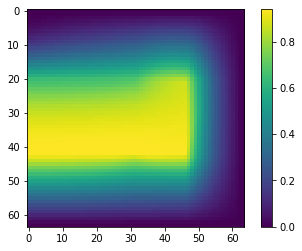

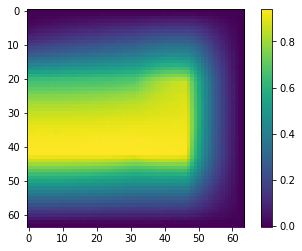

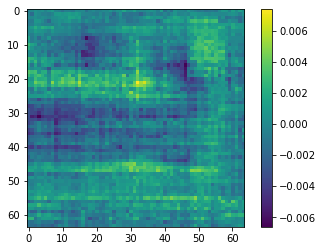

In [136]:
i, o = generate_batch(2)

n = model(i.to(device_name).to(tn.float32)).cpu()

plt.figure()
plt.imshow(o[0,...])
plt.colorbar()

plt.figure()
plt.imshow(n[0,...].detach())
plt.colorbar()

plt.figure()
plt.imshow(n[0,...].detach()-o[0,...])
plt.colorbar()

In [1]:
sum([ tn.numel(t) for t in list(model.parameters())])
dofs_tt

NameError: name 'model' is not defined